In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import pointCollection as pc

In [2]:
%matplotlib inline

In [3]:
import scattering_delays as sd

In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
def gaussian(t, μ, σ):
    return 1/(σ*np.sqrt(2*np.pi))*np.exp(-1/2*((t-μ)/σ)**2)

## Calculate the expected surface return function for a specified density and grain size

This notebook demonstrates the python code needed to recreate the results of the Matlab code for reducing MC files to SRF files.  The only missing step is writing the hdf5 output.

In [6]:
# load the old SRF information
with h5py.File('../../ATM_waveform/data/SRF_green_full.h5','r') as h5f:
    SRF_0={field:np.array(h5f[field]) for field in ['p','r_eff','t']}

In [12]:
# read the MC results.  The second argument is the number of photons in each file
D_MC=sd.read_MC_results('..//mc_code/1_layer', 1.e7, max_files=2)


In [10]:
! ls ../mc_code/1_layer/


mc_out_1.dat  mc_out_3.dat  mc_out_5.dat	  mc_out_output_format.txt
mc_out_2.dat  mc_out_4.dat  mc_out_N_photons.txt


In [13]:
LUT={}#None
SRF={}
sigma_wf=0.1*1.e-9  # small sigma, but big enough that the Gaussian is well defined for all bins
t=SRF_0['t']
λ=532e-9
ρ_s=400
t_wf=SRF_0['t']
t_win=2*t_wf[-1]
r_vals=SRF_0['r_eff']
v=sd.v_eff(λ, ρ_s)

for kr, r in enumerate(r_vals):
    SRF[r]={}
    # calculate the optical properties
    mu_e, mu_s, mu_a, g = sd.optical_properties_pure_snow(r, λ, ρ_s, LUT=LUT)
    
    # choose a time vector
    L_s=1/mu_s;
    #t_s=L_s/1.5e8;
    t_s=L_s/v
    t1=np.logspace(np.log10(0.025*t_s), np.log10(t_win), 3000)
    
    t1=np.concatenate((t1, t1[-1]+np.arange(0.1, 40.1, 0.1)*1e-9))

    # calculate the energy in the return, 
    R, R_tail = sd.R_from_MC(t1, mu_s, mu_a, g, v, D_MC)

    # Algebraic convolution between the IRF and the SRF
    delta_t=np.concatenate((t1[1:]-t1[0:-1], [t1[-1]-t1[-2]]))
    G=np.zeros((len(t_wf), len(t1)));
    for k, ti in enumerate(t_wf):
        these=np.abs(t1-ti) < 12*sigma_wf;
        if np.any(these):
            # the kth row of G multiplies the attenuated normalized photon counts
            # by a Gaussian centered on t_wf(k) evaluated at t1, times the delta_t values associated with t1 (dt)
            G[k,these]=gaussian(t1[these], ti, sigma_wf)*delta_t[these];
       
    P_wf=G.dot(R)

    # save the output
    SRF[r]['t']=t_wf
    SRF[r]['R']=R
    SRF[r]['R_tail']=R_tail
    SRF[r]['P']=P_wf


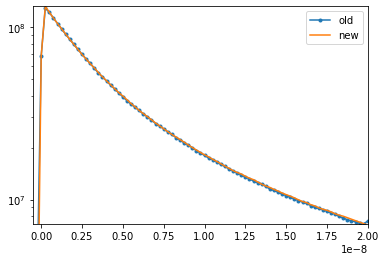

In [14]:
r_vals=SRF_0['r_eff']
plt.figure(); 
ii=-8

plt.semilogy(SRF_0['t'], SRF_0['p'][ii,:],marker='.', label='old')
plt.semilogy(SRF[r_vals[ii]]['t'], SRF[r_vals[ii]]['P'], label='new')
yl=[np.min(SRF_0['p'][ii, SRF_0['t']>1.e-9]), np.max(SRF[r_vals[ii]]['P'])]

plt.gca().set_xlim([-0.5e-9, np.max(SRF_0['t'])])
plt.gca().set_ylim(yl)
plt.legend()

In [ ]:
len(r_vals)

In [ ]:
SRF_new={}
SRF_new['r_eff'] = np.array(list(SRF.keys()))
SRF_new['t']=t_wf
SRF_new['p']=np.c_[[SRF[r]['P'] for r in SRF_new['r_eff']]]

In [ ]:
try:
    with h5py.File(out_file,'w') as h5f:
        for key in ['p','r_eff','t']:
            h5f.create_dataset(key, data=SRF_new[key])
except NameError:
    print("out_file not defined, skipping")

In [ ]:
{key: SRF_new[key].shape for key in SRF_new.keys()}

In [ ]:
# layer thicknesses:  from 5 cm to 2 m
z_layer=np.logspace(np.log10(0.05), np.log10(2), 20)
# scattering lengths: from 5 mm to 0.50 m
L_scat=np.logspace(np.log10(0.005), np.log10(0.5), 31)
L_scat

In [ ]:
z_layer

In [ ]:
MC_dir='/Users/ben/git_repos/scattering_optics/mc_code/1_layer'
D_MC=sd.read_MC_results(MC_dir,1.e7, τ=np.Inf)

In [17]:
Ke, Ks, Ka, g = sd.optical_properties_pure_snow(1.e-1, 917e-9, 400)
Ks*(1-g)

0.7652396777068208

In [21]:
Ke, Ks, Ka, g = sd.optical_properties_pure_snow(1.e-1, 532e-9, 917)
Ka

0.022284582607163372

In [22]:
# bounding values: for r=0.1 (golf balls?), \mu_s*(1-g) is around 1
# for r=1.e-5, \mu_s(1-g) is around 10000

μ_s=np.logspace(-np.log10(2), 3, 70)
μ_a=np.zeros_like(μ_s)
g=np.zeros_like(μ_s)
v=sd.v_eff(532e-9, 917)


In [40]:
SRF_dir='SRF_of_z_0.5ns'
dt=0.5e-9

#! [ -d {SRF_dir} ] && rm -rf {SRF_dir}
! [ -d {SRF_dir} ] || mkdir {SRF_dir}

In [41]:
Ke, Ks, Ka, g = sd.optical_properties_pure_snow(1.e-1, 532e-9, 917)

# bounding values: for r=0.1 (golf balls?), \mu_s*(1-g) is around 1
# for r=1.e-5, \mu_s(1-g) is around 10000

μ_s=np.logspace(-np.log10(2), 3, 70)
μ_a=np.zeros_like(μ_s)+Ka
g=np.zeros_like(μ_s)
v=sd.v_eff(532e-9, 917)

t_wf=np.arange(-4.e-8, 4.e-8+dt, dt)

SRF_inf=sd.make_srf_catalog(D_MC=D_MC,
                        μ_s=μ_s, μ_a=μ_a, g=g, t_wf=t_wf, v=sd.v_eff(532e-9, 917))

SRF_new={}
SRF_new['K'] = np.array(list(SRF_inf.keys()))
SRF_new['t']=t_wf
SRF_new['p']=np.c_[[SRF_inf[K]['P'] for K in SRF_inf.keys()]]

out_file=f'{SRF_dir}/SRF_green_full.h5'
with h5py.File(f'{SRF_dir}/SRF_green_full.h5','w') as h5f:
    for key in ['p','K','t']:
        h5f.create_dataset(key, data=SRF_new[key])


In [37]:
! ls {MC_dir}

mc_out_1.dat  mc_out_3.dat  mc_out_5.dat	  mc_out_output_format.txt
mc_out_2.dat  mc_out_4.dat  mc_out_N_photons.txt


In [38]:
SAVE_H5=True
DOPLOT=False

MC_dir='../mc_code/1_layer'
this_g=0
t_wf=np.arange(-4.e-8, 4.e-8+dt, dt)
v=sd.v_eff(532e-9, 917)
! [ -d SRF_of_z ] || mkdir SRF_of_z

srf_base=f'{SRF_dir}/SRF_green_z_%3.3f.h5'

# for testing:
#μ_s = np.logspace(0, 4, 5)
#z_layer=[0.1, 0.2, 0.5]

#  for production work: 
μ_s=np.logspace(-np.log10(2), 3, 70)
z_layer=np.logspace(-1, 0, 5)

E0=np.zeros((len(μ_s), len(z_layer)))
E1=E0.copy()

for z_count, zi in enumerate(z_layer):
    if DOPLOT:
        plt.figure()
        plt.gca().set_title(f'z_layer={zi}')
    SRF_cat={'K':μ_s, 't':t_wf, 'p':np.zeros([len(μ_s), len(t_wf)]), 'E_tot':np.zeros(len(μ_s))}
    for count, μi in enumerate(μ_s):
        τ_layer = zi*μi*(1-this_g)
        print([zi, τ_layer])
        Di_MC=sd.read_MC_results(MC_dir,1.e7, τ=τ_layer, max_files=2)
        dt = (Di_MC['lb']-Di_MC['la'])/μi/v
        if τ_layer < 3:
            τ_diverge=2*τ_layer
        else:
            τ_diverge = τ_layer + 1/3*τ_layer**2
        SRF_cat['p'][count, :], SRF_cat['E_tot'][count]=sd.calc_srf(t_wf, μi, 0, 0, v, Di_MC, 
                                           τ_exp = τ_diverge,
                                           skip_tail=False)
        
        t_mc=Di_MC['lc']/μi/v  # (m^-1)-1/(m/s) = s
        if DOPLOT:
            hh=plt.semilogy(t_mc*v, Di_MC['E']/dt, '.', label=μi)
            plt.semilogy(t_wf*v, SRF_cat['p'][count,:], color=hh[0].get_color())
        E0[count, z_count]=np.sum(SRF_cat['p'][count,:]*0.25e-9)
        E1[count, z_count]=SRF_cat['E_tot'][count]
    if SAVE_H5:
        with h5py.File(srf_base % zi, 'w') as h5f:
            for key, val in SRF_cat.items():
                h5f.create_dataset(key, data=val)
    if DOPLOT:
        plt.gca().set_xlim([-0.1, t_wf[-1]*v*1.1])
        plt.gca().set_ylim([1e-5, 1e12])
        plt.legend()

[0.1, 0.05]
[0.1, 0.055822723188187054]
[0.1, 0.06232352848289912]
[0.1, 0.06958138157223936]
[0.1, 0.07768444405117475]
[0.1, 0.08673114432593865]
[0.1, 0.09683137323003144]
[0.1, 0.1081078188750414]
[0.1, 0.12069745695080199]
[0.1, 0.13475321457765485]
[0.1, 0.15044582792173597]
[0.1, 0.16796591613785375]
[0.1, 0.18752629683227295]
[0.1, 0.20936457117147547]
[0.1, 0.23374601003837517]
[0.1, 0.2609667762943082]
[0.1, 0.291357522287814]
[0.1, 0.3252874063093736]
[0.1, 0.36316857678022985]
[0.1, 0.40546117864501235]
[0.1, 0.45267894278113174]
[0.1, 0.5053954263198454]
[0.1, 0.5642509796805703]
[0.1, 0.6299605249474367]
[0.1, 0.7033222400725149]
[0.1, 0.7852272543932728]
[0.1, 0.8766704732363162]
[0.1, 0.9787626630945564]
[0.1, 1.0927439441772036]
[0.1, 1.2199988542274354]
[0.1, 1.36207316658887]
[0.1, 1.5206926668109568]
[0.1, 1.6977841158738802]
[0.1, 1.8954986546745702]
[0.1, 2.1162379340695887]
[0.1, 2.36268328787815]
[0.1, 2.6378283032115526]
[0.1, 2.9450151837628717]
[0.1, 3.287975

[0.5623413251903491, 1.6384237518750597]
[0.5623413251903491, 1.8292255113174463]
[0.5623413251903491, 2.042246987340875]
[0.5623413251903491, 2.2800757651247707]
[0.5623413251903491, 2.545600765693078]
[0.5623413251903491, 2.8420473378184323]
[0.5623413251903491, 3.1730164365352462]
[0.5623413251903491, 3.5425283641654945]
[0.5623413251903491, 3.955071605182228]
[0.5623413251903491, 4.415657348110924]
[0.5623413251903491, 4.929880356749605]
[0.5623413251903491, 5.50398693011428]
[0.5623413251903491, 6.144950776623375]
[0.5623413251903491, 6.8605577241696345]
[0.5623413251903491, 7.659500295058002]
[0.5623413251903491, 8.551483294617194]
[0.5623413251903491, 9.54734169607643]
[0.5623413251903491, 10.659172253662216]
[0.5623413251903491, 11.90048044262779]
[0.5623413251903491, 13.286344511104899]
[0.5623413251903491, 14.833598636525943]
[0.5623413251903491, 16.561037411429126]
[0.5623413251903491, 18.489644142548357]
[0.5623413251903491, 20.642845736351223]
[0.5623413251903491, 23.04679

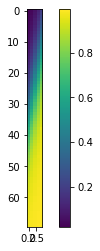

In [30]:
plt.figure(); 
plt.imshow(E1); plt.colorbar()

In [ ]:
μi=100
zi=0.5
this_g=0
v=sd.v_eff(532e-9, 917)

τ_layer = zi*μi*(1-this_g)
print([zi, τ_layer])
MC_dir='../MC_code/1_layer'
Di_MC=sd.read_MC_results(MC_dir, 1.e7, τ=τ_layer)

dt=2.5e-10
t_wf=np.arange(-2.e-8, 2.e-8+dt, dt)


if τ_layer < 3:
    τ_diverge=2*τ_layer
else:
    τ_diverge = τ_layer + 1/3*τ_layer**2
pp, ee=so.calc_srf(t_wf, μi, 0, 0, v, Di_MC, 
                                   τ_exp = τ_diverge,
                                   skip_tail=False)


## More testing: Layers of consistent optical thickness 

...for different z.  This is much faster than rereading the MC results every time

In [ ]:
τ_layer=np.array([0.1, 0.3, 1, 2, 10, 100, 1000])
z_layer=np.arange(0.1, 1, 0.1)

this_g=0
v=sd.v_eff(532e-9, 917)
MC_dir='../MC_code/1_layer'
dt=0.25e-9
t_wf=np.arange(-2.e-8, 2.e-8+dt, dt)

R_catalog={}

hf, hax=plt.subplots(len(τ_layer), 1, figsize=[6, 2*len(τ_layer)])

for τi, ha in zip(τ_layer, hax):
    Di_MC=sd.read_MC_results(MC_dir, 1.e7, τ=τi)
    
    if τi < 3:
        τ_diverge=2*τi
    else:
        τ_diverge = τi + 1/3*τi**2
    
    for zi in z_layer:
        μi = τi/zi
        #print(f'\t {[zi, μi]}')
        L_s=1/μi;
        t_s=L_s/v;
        t_win = 2*t_wf[-1]
    
        t1=np.logspace(np.log10(0.025*t_s), np.log10(t_win), 3000)
        t1=np.concatenate((t1, t1[-1]+np.arange(0.1, 40.1, 0.1)*1e-9))

        # calculate the energy in the return,
        R, R_tail = sd.R_from_MC( t1, μi, 0, this_g, v, Di_MC, τ_exp=τ_diverge )
        Rbar=(R[1:]+R[0:-1])/2
        dt=np.diff(t1)
        E_tot=np.sum(Rbar*dt)+R_tail
        ha.semilogy(t1, R, label=f'z={zi}')
        R_catalog[(τi,zi)]={'t':t1, 'R':R, 'R_tail':R_tail,'E_tot':E_tot}
plt.legend()
    

In [ ]:
RR=np.zeros((len(τ_layer), len(z_layer)))+np.NaN

for row, τi in enumerate(τ_layer):
    for col, zi in enumerate(z_layer):
        RR[row, col]=R_catalog[(τi,zi)]['E_tot']
plt.figure(); plt.semilogx(τ_layer, RR, marker='.')
plt.gca().set_xlabel("τ")
plt.gca().set_ylabel("R")